# Conditional GAN

Import the modules.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Activation, Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse

Using TensorFlow backend.


# The generator network
This network consists of four deconvolutional layers. First, I take our input z-vector and labels and concatenated before Dense layer, the feed it into the first deconvolutional layer. Each deconvolutional layer performs a deconvolution operations and then performs batch normalization operations and a leaky ReLu operations as well. Then, finally it return the sigmoid activation function.

The Model instance is modified for the z-vector and one-hot vector inputs.

In [2]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model
    Inputs are concatenated before Dense layer.
    Stack of BatchNormalization-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.
    # Arguments
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator

# The discriminator network
The discriminator is the “art critic”, who tries to distinguish between real and fake images. This is a convolutional neural network for image classification. The discriminator network consists of four stack of LeakyReLU-Conv2D. For every layer of the network, I am adding LeakyReLU and convolutional operations, Then, finally it return the sigmoid activation function.

The code processes the one-hot vector using a Dense layer and concatenates it with the image input. The Model instance is modified for the image and one-hot vector inputs.

In [3]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model
    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.
    # Arguments
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)
    # Returns
        Model: Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

# Training
The CGAN discriminator is firstly trained with one batch of real and fake data conditioned on their respective one-hot labels. Then, the generator parameters are updated by training the adversarial network given one-hot label conditioned fake data pretending to be real. Similar to DCGAN, the discriminator weights are frozen during adversarial training.

In [4]:
def train(models, data, params):
    """Train the Discriminator and Adversarial Networks
    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.
    # Arguments
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters
    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels w/ label=1.0
        # since the discriminator weights are frozen in adversarial network
        # only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial
        # for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            if (i + 1) == train_steps:
                show = True
            else:
                show = False

            # plot generator images on a periodic basis
            plot_images(generator,noise_input=noise_input,noise_class=noise_class,show=show, step=(i + 1),model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for future MNIST digit generation
    generator.save(model_name + ".h5")

# Visualization

In the last step of our preparation, This is small helper function to display the generated images in the notebook for us, using the matplotlib library.

In [5]:
def plot_images(generator,noise_input,noise_class,show=False,step=0,model_name="gan"):
    """Generate fake images and plot them
    For visualization purposes, generate fake images
    then plot them in a square grid
    # Arguments
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name
    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

# Build And Train Models

In [6]:
def build_and_train_models():
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    # the latent or z vector is 100-dim
    latent_size = 100
    batch_size = 64
    train_steps = 4000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    # [1] or original paper uses Adam, 
    # but discriminator converges easily with RMSprop
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    discriminator.summary()

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    # freeze the weights of discriminator during adversarial training
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],outputs,name=model_name)
    adversarial.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    adversarial.summary()

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)

In [7]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,noise_input=noise_input,noise_class=noise_class,show=True,step=step,model_name="test_outputs")

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 784)          8624        class_labels[0][0]               
__________________________________________________________________________________________________
discriminator_input (InputLayer (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           dense_1[0][0]                    
__________________________________________________________________________________________________
concatenat

C:\Users\maninaya\Anaconda3\envs\env\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.693949, acc: 0.398438] [adversarial loss: 1.280427, acc: 0.000000]
1: [discriminator loss: 0.604973, acc: 0.500000] [adversarial loss: 1.701057, acc: 0.000000]
2: [discriminator loss: 0.479374, acc: 0.812500] [adversarial loss: 1.689416, acc: 0.000000]
3: [discriminator loss: 0.339849, acc: 1.000000] [adversarial loss: 3.346819, acc: 0.000000]
4: [discriminator loss: 0.266478, acc: 0.945312] [adversarial loss: 1.145521, acc: 0.000000]
5: [discriminator loss: 0.356519, acc: 1.000000] [adversarial loss: 4.918969, acc: 0.000000]
6: [discriminator loss: 0.249324, acc: 0.921875] [adversarial loss: 2.853182, acc: 0.000000]
7: [discriminator loss: 0.107997, acc: 0.992188] [adversarial loss: 2.444647, acc: 0.000000]
8: [discriminator loss: 0.093041, acc: 0.992188] [adversarial loss: 2.005009, acc: 0.000000]
9: [discriminator loss: 0.063101, acc: 1.000000] [adversarial loss: 2.015433, acc: 0.000000]
10: [discriminator loss: 0.069285, acc: 0.992188] [adversarial loss: 1

88: [discriminator loss: 0.384047, acc: 0.882812] [adversarial loss: 0.541381, acc: 0.953125]
89: [discriminator loss: 0.680269, acc: 0.500000] [adversarial loss: 4.420385, acc: 0.000000]
90: [discriminator loss: 1.258720, acc: 0.570312] [adversarial loss: 0.474724, acc: 1.000000]
91: [discriminator loss: 0.788282, acc: 0.500000] [adversarial loss: 2.205306, acc: 0.000000]
92: [discriminator loss: 0.390835, acc: 0.843750] [adversarial loss: 0.939355, acc: 0.046875]
93: [discriminator loss: 0.346713, acc: 0.914062] [adversarial loss: 1.949677, acc: 0.000000]
94: [discriminator loss: 0.297949, acc: 0.937500] [adversarial loss: 1.121472, acc: 0.000000]
95: [discriminator loss: 0.286829, acc: 0.976562] [adversarial loss: 1.690777, acc: 0.000000]
96: [discriminator loss: 0.276471, acc: 0.945312] [adversarial loss: 1.159191, acc: 0.000000]
97: [discriminator loss: 0.285608, acc: 1.000000] [adversarial loss: 2.205151, acc: 0.000000]
98: [discriminator loss: 0.468078, acc: 0.804688] [adversari

175: [discriminator loss: 0.549565, acc: 0.632812] [adversarial loss: 1.703334, acc: 0.015625]
176: [discriminator loss: 0.491939, acc: 0.750000] [adversarial loss: 0.586812, acc: 0.703125]
177: [discriminator loss: 0.543696, acc: 0.695312] [adversarial loss: 1.893637, acc: 0.000000]
178: [discriminator loss: 0.542015, acc: 0.734375] [adversarial loss: 0.357144, acc: 0.953125]
179: [discriminator loss: 0.536165, acc: 0.640625] [adversarial loss: 1.609533, acc: 0.015625]
180: [discriminator loss: 0.515463, acc: 0.726562] [adversarial loss: 0.552346, acc: 0.734375]
181: [discriminator loss: 0.545691, acc: 0.656250] [adversarial loss: 1.848547, acc: 0.000000]
182: [discriminator loss: 0.645091, acc: 0.554688] [adversarial loss: 0.152213, acc: 1.000000]
183: [discriminator loss: 0.727324, acc: 0.515625] [adversarial loss: 1.498623, acc: 0.015625]
184: [discriminator loss: 0.531910, acc: 0.687500] [adversarial loss: 0.307370, acc: 1.000000]
185: [discriminator loss: 0.673567, acc: 0.562500]

262: [discriminator loss: 0.642164, acc: 0.546875] [adversarial loss: 0.425057, acc: 0.953125]
263: [discriminator loss: 0.654329, acc: 0.531250] [adversarial loss: 1.596988, acc: 0.000000]
264: [discriminator loss: 0.643955, acc: 0.554688] [adversarial loss: 0.478160, acc: 0.890625]
265: [discriminator loss: 0.652950, acc: 0.515625] [adversarial loss: 1.510000, acc: 0.000000]
266: [discriminator loss: 0.615617, acc: 0.593750] [adversarial loss: 0.482773, acc: 0.890625]
267: [discriminator loss: 0.629391, acc: 0.515625] [adversarial loss: 1.529294, acc: 0.000000]
268: [discriminator loss: 0.594705, acc: 0.617188] [adversarial loss: 0.507298, acc: 0.859375]
269: [discriminator loss: 0.642002, acc: 0.546875] [adversarial loss: 1.579219, acc: 0.000000]
270: [discriminator loss: 0.630565, acc: 0.585938] [adversarial loss: 0.464558, acc: 0.890625]
271: [discriminator loss: 0.647349, acc: 0.546875] [adversarial loss: 1.746850, acc: 0.000000]
272: [discriminator loss: 0.670524, acc: 0.531250]

349: [discriminator loss: 0.592311, acc: 0.593750] [adversarial loss: 1.230728, acc: 0.000000]
350: [discriminator loss: 0.633005, acc: 0.687500] [adversarial loss: 0.596964, acc: 0.781250]
351: [discriminator loss: 0.593898, acc: 0.656250] [adversarial loss: 1.092799, acc: 0.046875]
352: [discriminator loss: 0.596446, acc: 0.695312] [adversarial loss: 0.559665, acc: 0.781250]
353: [discriminator loss: 0.579518, acc: 0.679688] [adversarial loss: 1.038680, acc: 0.015625]
354: [discriminator loss: 0.583420, acc: 0.703125] [adversarial loss: 0.544318, acc: 0.812500]
355: [discriminator loss: 0.633822, acc: 0.617188] [adversarial loss: 1.357352, acc: 0.000000]
356: [discriminator loss: 0.655637, acc: 0.546875] [adversarial loss: 0.457695, acc: 0.937500]
357: [discriminator loss: 0.691292, acc: 0.554688] [adversarial loss: 1.569403, acc: 0.000000]
358: [discriminator loss: 0.715053, acc: 0.515625] [adversarial loss: 0.449372, acc: 0.890625]
359: [discriminator loss: 0.662587, acc: 0.546875]

436: [discriminator loss: 0.646096, acc: 0.585938] [adversarial loss: 0.567950, acc: 0.734375]
437: [discriminator loss: 0.636374, acc: 0.578125] [adversarial loss: 1.291237, acc: 0.000000]
438: [discriminator loss: 0.624100, acc: 0.609375] [adversarial loss: 0.546267, acc: 0.781250]
439: [discriminator loss: 0.629453, acc: 0.578125] [adversarial loss: 1.184627, acc: 0.015625]
440: [discriminator loss: 0.646192, acc: 0.562500] [adversarial loss: 0.512832, acc: 0.890625]
441: [discriminator loss: 0.669427, acc: 0.539062] [adversarial loss: 1.276497, acc: 0.000000]
442: [discriminator loss: 0.685447, acc: 0.562500] [adversarial loss: 0.427809, acc: 0.968750]
443: [discriminator loss: 0.699482, acc: 0.523438] [adversarial loss: 1.430298, acc: 0.000000]
444: [discriminator loss: 0.711513, acc: 0.546875] [adversarial loss: 0.505471, acc: 0.875000]
445: [discriminator loss: 0.672040, acc: 0.539062] [adversarial loss: 1.456771, acc: 0.000000]
446: [discriminator loss: 0.709272, acc: 0.546875]

522: [discriminator loss: 0.631379, acc: 0.632812] [adversarial loss: 0.624012, acc: 0.640625]
523: [discriminator loss: 0.601596, acc: 0.625000] [adversarial loss: 0.942782, acc: 0.046875]
524: [discriminator loss: 0.589044, acc: 0.742188] [adversarial loss: 0.699059, acc: 0.500000]
525: [discriminator loss: 0.613598, acc: 0.679688] [adversarial loss: 0.870588, acc: 0.218750]
526: [discriminator loss: 0.599517, acc: 0.695312] [adversarial loss: 0.773313, acc: 0.328125]
527: [discriminator loss: 0.634890, acc: 0.609375] [adversarial loss: 1.022208, acc: 0.093750]
528: [discriminator loss: 0.583328, acc: 0.703125] [adversarial loss: 0.685906, acc: 0.562500]
529: [discriminator loss: 0.611116, acc: 0.648438] [adversarial loss: 1.267606, acc: 0.015625]
530: [discriminator loss: 0.651864, acc: 0.617188] [adversarial loss: 0.432843, acc: 0.921875]
531: [discriminator loss: 0.778065, acc: 0.468750] [adversarial loss: 1.898060, acc: 0.000000]
532: [discriminator loss: 0.856667, acc: 0.523438]

609: [discriminator loss: 0.582208, acc: 0.703125] [adversarial loss: 0.622135, acc: 0.671875]
610: [discriminator loss: 0.620346, acc: 0.601562] [adversarial loss: 1.583388, acc: 0.000000]
611: [discriminator loss: 0.694215, acc: 0.578125] [adversarial loss: 0.413305, acc: 0.921875]
612: [discriminator loss: 0.722900, acc: 0.523438] [adversarial loss: 1.673454, acc: 0.000000]
613: [discriminator loss: 0.811627, acc: 0.492188] [adversarial loss: 0.497019, acc: 0.843750]
614: [discriminator loss: 0.645385, acc: 0.539062] [adversarial loss: 1.151358, acc: 0.031250]
615: [discriminator loss: 0.632740, acc: 0.648438] [adversarial loss: 0.683454, acc: 0.546875]
616: [discriminator loss: 0.627823, acc: 0.632812] [adversarial loss: 1.128609, acc: 0.031250]
617: [discriminator loss: 0.613337, acc: 0.601562] [adversarial loss: 0.613416, acc: 0.718750]
618: [discriminator loss: 0.604541, acc: 0.601562] [adversarial loss: 0.977944, acc: 0.109375]
619: [discriminator loss: 0.608318, acc: 0.664062]

696: [discriminator loss: 0.595864, acc: 0.703125] [adversarial loss: 0.702100, acc: 0.484375]
697: [discriminator loss: 0.628143, acc: 0.664062] [adversarial loss: 1.181496, acc: 0.062500]
698: [discriminator loss: 0.628382, acc: 0.648438] [adversarial loss: 0.586484, acc: 0.750000]
699: [discriminator loss: 0.579772, acc: 0.664062] [adversarial loss: 1.272405, acc: 0.015625]
700: [discriminator loss: 0.606274, acc: 0.648438] [adversarial loss: 0.662028, acc: 0.625000]
701: [discriminator loss: 0.624447, acc: 0.625000] [adversarial loss: 1.309610, acc: 0.015625]
702: [discriminator loss: 0.616635, acc: 0.648438] [adversarial loss: 0.662924, acc: 0.609375]
703: [discriminator loss: 0.602608, acc: 0.648438] [adversarial loss: 1.217567, acc: 0.078125]
704: [discriminator loss: 0.617403, acc: 0.640625] [adversarial loss: 0.671887, acc: 0.593750]
705: [discriminator loss: 0.585635, acc: 0.609375] [adversarial loss: 1.424228, acc: 0.015625]
706: [discriminator loss: 0.642026, acc: 0.617188]

783: [discriminator loss: 0.610609, acc: 0.687500] [adversarial loss: 1.092016, acc: 0.093750]
784: [discriminator loss: 0.574660, acc: 0.765625] [adversarial loss: 0.525226, acc: 0.765625]
785: [discriminator loss: 0.678431, acc: 0.625000] [adversarial loss: 1.582955, acc: 0.031250]
786: [discriminator loss: 0.680688, acc: 0.562500] [adversarial loss: 0.506569, acc: 0.828125]
787: [discriminator loss: 0.635031, acc: 0.546875] [adversarial loss: 1.404669, acc: 0.015625]
788: [discriminator loss: 0.611308, acc: 0.632812] [adversarial loss: 0.569838, acc: 0.750000]
789: [discriminator loss: 0.659628, acc: 0.632812] [adversarial loss: 1.238244, acc: 0.015625]
790: [discriminator loss: 0.646594, acc: 0.617188] [adversarial loss: 0.568121, acc: 0.765625]
791: [discriminator loss: 0.674642, acc: 0.570312] [adversarial loss: 1.415069, acc: 0.000000]
792: [discriminator loss: 0.649874, acc: 0.554688] [adversarial loss: 0.628720, acc: 0.734375]
793: [discriminator loss: 0.601737, acc: 0.648438]

870: [discriminator loss: 0.600375, acc: 0.609375] [adversarial loss: 0.746213, acc: 0.562500]
871: [discriminator loss: 0.600219, acc: 0.632812] [adversarial loss: 1.245679, acc: 0.062500]
872: [discriminator loss: 0.638031, acc: 0.656250] [adversarial loss: 0.728080, acc: 0.468750]
873: [discriminator loss: 0.596547, acc: 0.656250] [adversarial loss: 0.959030, acc: 0.203125]
874: [discriminator loss: 0.572341, acc: 0.703125] [adversarial loss: 0.712547, acc: 0.484375]
875: [discriminator loss: 0.562000, acc: 0.695312] [adversarial loss: 1.109985, acc: 0.156250]
876: [discriminator loss: 0.597403, acc: 0.703125] [adversarial loss: 0.720955, acc: 0.546875]
877: [discriminator loss: 0.587662, acc: 0.679688] [adversarial loss: 1.197391, acc: 0.046875]
878: [discriminator loss: 0.627333, acc: 0.640625] [adversarial loss: 0.620023, acc: 0.687500]
879: [discriminator loss: 0.621225, acc: 0.632812] [adversarial loss: 1.594458, acc: 0.000000]
880: [discriminator loss: 0.733688, acc: 0.539062]

957: [discriminator loss: 0.739243, acc: 0.507812] [adversarial loss: 0.499383, acc: 0.843750]
958: [discriminator loss: 0.642574, acc: 0.625000] [adversarial loss: 1.210492, acc: 0.109375]
959: [discriminator loss: 0.620452, acc: 0.664062] [adversarial loss: 0.678369, acc: 0.578125]
960: [discriminator loss: 0.629706, acc: 0.617188] [adversarial loss: 1.252714, acc: 0.062500]
961: [discriminator loss: 0.584070, acc: 0.671875] [adversarial loss: 0.674226, acc: 0.562500]
962: [discriminator loss: 0.673715, acc: 0.585938] [adversarial loss: 1.127228, acc: 0.125000]
963: [discriminator loss: 0.675192, acc: 0.609375] [adversarial loss: 0.871054, acc: 0.359375]
964: [discriminator loss: 0.560284, acc: 0.757812] [adversarial loss: 1.031655, acc: 0.156250]
965: [discriminator loss: 0.577681, acc: 0.734375] [adversarial loss: 0.862916, acc: 0.343750]
966: [discriminator loss: 0.541509, acc: 0.750000] [adversarial loss: 1.008661, acc: 0.203125]
967: [discriminator loss: 0.596593, acc: 0.687500]

1042: [discriminator loss: 0.631306, acc: 0.632812] [adversarial loss: 1.101032, acc: 0.265625]
1043: [discriminator loss: 0.641372, acc: 0.632812] [adversarial loss: 0.655983, acc: 0.609375]
1044: [discriminator loss: 0.633323, acc: 0.609375] [adversarial loss: 1.185338, acc: 0.078125]
1045: [discriminator loss: 0.662469, acc: 0.562500] [adversarial loss: 0.573548, acc: 0.718750]
1046: [discriminator loss: 0.675925, acc: 0.570312] [adversarial loss: 1.404621, acc: 0.078125]
1047: [discriminator loss: 0.668987, acc: 0.632812] [adversarial loss: 0.606909, acc: 0.609375]
1048: [discriminator loss: 0.690109, acc: 0.523438] [adversarial loss: 1.158571, acc: 0.078125]
1049: [discriminator loss: 0.674228, acc: 0.617188] [adversarial loss: 0.667036, acc: 0.593750]
1050: [discriminator loss: 0.605461, acc: 0.687500] [adversarial loss: 1.122470, acc: 0.109375]
1051: [discriminator loss: 0.640689, acc: 0.632812] [adversarial loss: 0.682128, acc: 0.546875]
1052: [discriminator loss: 0.621409, acc

1128: [discriminator loss: 0.606476, acc: 0.687500] [adversarial loss: 0.790519, acc: 0.328125]
1129: [discriminator loss: 0.616247, acc: 0.671875] [adversarial loss: 0.894705, acc: 0.250000]
1130: [discriminator loss: 0.640455, acc: 0.625000] [adversarial loss: 0.830218, acc: 0.453125]
1131: [discriminator loss: 0.582758, acc: 0.726562] [adversarial loss: 1.033438, acc: 0.203125]
1132: [discriminator loss: 0.633744, acc: 0.625000] [adversarial loss: 0.669681, acc: 0.546875]
1133: [discriminator loss: 0.671780, acc: 0.617188] [adversarial loss: 1.214523, acc: 0.109375]
1134: [discriminator loss: 0.652386, acc: 0.617188] [adversarial loss: 0.586625, acc: 0.671875]
1135: [discriminator loss: 0.696722, acc: 0.554688] [adversarial loss: 1.174874, acc: 0.171875]
1136: [discriminator loss: 0.691520, acc: 0.546875] [adversarial loss: 0.606617, acc: 0.671875]
1137: [discriminator loss: 0.658306, acc: 0.570312] [adversarial loss: 1.236569, acc: 0.078125]
1138: [discriminator loss: 0.684204, acc

1214: [discriminator loss: 0.730822, acc: 0.523438] [adversarial loss: 1.004028, acc: 0.093750]
1215: [discriminator loss: 0.638094, acc: 0.664062] [adversarial loss: 0.672843, acc: 0.578125]
1216: [discriminator loss: 0.715575, acc: 0.601562] [adversarial loss: 0.952519, acc: 0.156250]
1217: [discriminator loss: 0.639518, acc: 0.687500] [adversarial loss: 0.719276, acc: 0.437500]
1218: [discriminator loss: 0.636467, acc: 0.632812] [adversarial loss: 0.897310, acc: 0.171875]
1219: [discriminator loss: 0.630076, acc: 0.593750] [adversarial loss: 0.793843, acc: 0.343750]
1220: [discriminator loss: 0.683357, acc: 0.593750] [adversarial loss: 0.826646, acc: 0.250000]
1221: [discriminator loss: 0.667326, acc: 0.640625] [adversarial loss: 0.778121, acc: 0.359375]
1222: [discriminator loss: 0.654706, acc: 0.625000] [adversarial loss: 0.958089, acc: 0.125000]
1223: [discriminator loss: 0.654001, acc: 0.593750] [adversarial loss: 0.714249, acc: 0.468750]
1224: [discriminator loss: 0.672869, acc

1300: [discriminator loss: 0.694289, acc: 0.570312] [adversarial loss: 0.998175, acc: 0.140625]
1301: [discriminator loss: 0.637122, acc: 0.632812] [adversarial loss: 0.764809, acc: 0.406250]
1302: [discriminator loss: 0.611867, acc: 0.679688] [adversarial loss: 0.774871, acc: 0.406250]
1303: [discriminator loss: 0.672051, acc: 0.531250] [adversarial loss: 0.866085, acc: 0.218750]
1304: [discriminator loss: 0.617048, acc: 0.687500] [adversarial loss: 0.727536, acc: 0.500000]
1305: [discriminator loss: 0.642165, acc: 0.625000] [adversarial loss: 0.955830, acc: 0.234375]
1306: [discriminator loss: 0.677664, acc: 0.578125] [adversarial loss: 0.705239, acc: 0.531250]
1307: [discriminator loss: 0.721419, acc: 0.507812] [adversarial loss: 1.024941, acc: 0.125000]
1308: [discriminator loss: 0.672469, acc: 0.593750] [adversarial loss: 0.708434, acc: 0.468750]
1309: [discriminator loss: 0.624307, acc: 0.679688] [adversarial loss: 0.955417, acc: 0.296875]
1310: [discriminator loss: 0.668657, acc

1386: [discriminator loss: 0.680056, acc: 0.570312] [adversarial loss: 1.054488, acc: 0.109375]
1387: [discriminator loss: 0.659286, acc: 0.593750] [adversarial loss: 0.584841, acc: 0.718750]
1388: [discriminator loss: 0.732680, acc: 0.507812] [adversarial loss: 1.061336, acc: 0.093750]
1389: [discriminator loss: 0.664469, acc: 0.585938] [adversarial loss: 0.608781, acc: 0.734375]
1390: [discriminator loss: 0.682454, acc: 0.554688] [adversarial loss: 1.088570, acc: 0.078125]
1391: [discriminator loss: 0.628896, acc: 0.648438] [adversarial loss: 0.727709, acc: 0.421875]
1392: [discriminator loss: 0.679556, acc: 0.531250] [adversarial loss: 0.882005, acc: 0.281250]
1393: [discriminator loss: 0.620758, acc: 0.656250] [adversarial loss: 0.965620, acc: 0.250000]
1394: [discriminator loss: 0.669787, acc: 0.625000] [adversarial loss: 0.807048, acc: 0.343750]
1395: [discriminator loss: 0.652739, acc: 0.664062] [adversarial loss: 1.043461, acc: 0.093750]
1396: [discriminator loss: 0.629616, acc

1472: [discriminator loss: 0.688351, acc: 0.570312] [adversarial loss: 0.698704, acc: 0.531250]
1473: [discriminator loss: 0.650824, acc: 0.640625] [adversarial loss: 0.787297, acc: 0.375000]
1474: [discriminator loss: 0.633560, acc: 0.664062] [adversarial loss: 0.799472, acc: 0.312500]
1475: [discriminator loss: 0.643490, acc: 0.625000] [adversarial loss: 0.793503, acc: 0.296875]
1476: [discriminator loss: 0.617014, acc: 0.695312] [adversarial loss: 0.916577, acc: 0.250000]
1477: [discriminator loss: 0.603983, acc: 0.726562] [adversarial loss: 0.867170, acc: 0.250000]
1478: [discriminator loss: 0.666257, acc: 0.601562] [adversarial loss: 0.814261, acc: 0.265625]
1479: [discriminator loss: 0.649764, acc: 0.601562] [adversarial loss: 0.993720, acc: 0.140625]
1480: [discriminator loss: 0.613764, acc: 0.617188] [adversarial loss: 0.713585, acc: 0.468750]
1481: [discriminator loss: 0.682210, acc: 0.617188] [adversarial loss: 1.043467, acc: 0.093750]
1482: [discriminator loss: 0.673095, acc

1557: [discriminator loss: 0.631879, acc: 0.664062] [adversarial loss: 0.793622, acc: 0.437500]
1558: [discriminator loss: 0.677844, acc: 0.640625] [adversarial loss: 1.021479, acc: 0.187500]
1559: [discriminator loss: 0.670176, acc: 0.562500] [adversarial loss: 0.615968, acc: 0.609375]
1560: [discriminator loss: 0.681361, acc: 0.578125] [adversarial loss: 1.085216, acc: 0.125000]
1561: [discriminator loss: 0.716212, acc: 0.500000] [adversarial loss: 0.534402, acc: 0.859375]
1562: [discriminator loss: 0.684158, acc: 0.531250] [adversarial loss: 1.021414, acc: 0.156250]
1563: [discriminator loss: 0.636015, acc: 0.625000] [adversarial loss: 0.662741, acc: 0.625000]
1564: [discriminator loss: 0.673583, acc: 0.593750] [adversarial loss: 0.997565, acc: 0.140625]
1565: [discriminator loss: 0.691823, acc: 0.523438] [adversarial loss: 0.661702, acc: 0.625000]
1566: [discriminator loss: 0.706958, acc: 0.554688] [adversarial loss: 1.072605, acc: 0.125000]
1567: [discriminator loss: 0.658172, acc

1643: [discriminator loss: 0.705777, acc: 0.554688] [adversarial loss: 0.725502, acc: 0.421875]
1644: [discriminator loss: 0.674680, acc: 0.562500] [adversarial loss: 0.861152, acc: 0.265625]
1645: [discriminator loss: 0.656913, acc: 0.625000] [adversarial loss: 0.711979, acc: 0.515625]
1646: [discriminator loss: 0.665087, acc: 0.601562] [adversarial loss: 0.855890, acc: 0.265625]
1647: [discriminator loss: 0.667084, acc: 0.601562] [adversarial loss: 0.840741, acc: 0.296875]
1648: [discriminator loss: 0.652854, acc: 0.570312] [adversarial loss: 0.852554, acc: 0.312500]
1649: [discriminator loss: 0.679904, acc: 0.570312] [adversarial loss: 0.761473, acc: 0.421875]
1650: [discriminator loss: 0.644680, acc: 0.609375] [adversarial loss: 0.984607, acc: 0.109375]
1651: [discriminator loss: 0.655131, acc: 0.617188] [adversarial loss: 0.582461, acc: 0.718750]
1652: [discriminator loss: 0.669963, acc: 0.554688] [adversarial loss: 0.891975, acc: 0.203125]
1653: [discriminator loss: 0.663168, acc

1729: [discriminator loss: 0.665697, acc: 0.601562] [adversarial loss: 0.688892, acc: 0.578125]
1730: [discriminator loss: 0.674412, acc: 0.578125] [adversarial loss: 0.799441, acc: 0.312500]
1731: [discriminator loss: 0.609131, acc: 0.703125] [adversarial loss: 0.916733, acc: 0.281250]
1732: [discriminator loss: 0.728030, acc: 0.523438] [adversarial loss: 0.591640, acc: 0.687500]
1733: [discriminator loss: 0.693140, acc: 0.562500] [adversarial loss: 1.412010, acc: 0.000000]
1734: [discriminator loss: 0.781396, acc: 0.507812] [adversarial loss: 0.433885, acc: 0.906250]
1735: [discriminator loss: 0.753631, acc: 0.515625] [adversarial loss: 1.205364, acc: 0.015625]
1736: [discriminator loss: 0.674915, acc: 0.609375] [adversarial loss: 0.554229, acc: 0.765625]
1737: [discriminator loss: 0.649873, acc: 0.585938] [adversarial loss: 0.923343, acc: 0.187500]
1738: [discriminator loss: 0.673216, acc: 0.593750] [adversarial loss: 0.699296, acc: 0.546875]
1739: [discriminator loss: 0.684833, acc

1815: [discriminator loss: 0.708801, acc: 0.539062] [adversarial loss: 0.990648, acc: 0.140625]
1816: [discriminator loss: 0.721744, acc: 0.539062] [adversarial loss: 0.603022, acc: 0.609375]
1817: [discriminator loss: 0.679260, acc: 0.570312] [adversarial loss: 0.945580, acc: 0.046875]
1818: [discriminator loss: 0.680838, acc: 0.570312] [adversarial loss: 0.541297, acc: 0.765625]
1819: [discriminator loss: 0.676973, acc: 0.562500] [adversarial loss: 1.034972, acc: 0.140625]
1820: [discriminator loss: 0.706337, acc: 0.593750] [adversarial loss: 0.684196, acc: 0.578125]
1821: [discriminator loss: 0.677890, acc: 0.546875] [adversarial loss: 0.954214, acc: 0.140625]
1822: [discriminator loss: 0.656978, acc: 0.617188] [adversarial loss: 0.691381, acc: 0.468750]
1823: [discriminator loss: 0.712939, acc: 0.492188] [adversarial loss: 0.747074, acc: 0.468750]
1824: [discriminator loss: 0.673049, acc: 0.578125] [adversarial loss: 0.879090, acc: 0.093750]
1825: [discriminator loss: 0.659567, acc

1901: [discriminator loss: 0.748034, acc: 0.484375] [adversarial loss: 1.008532, acc: 0.046875]
1902: [discriminator loss: 0.709112, acc: 0.523438] [adversarial loss: 0.648538, acc: 0.625000]
1903: [discriminator loss: 0.690274, acc: 0.578125] [adversarial loss: 1.060805, acc: 0.046875]
1904: [discriminator loss: 0.667561, acc: 0.625000] [adversarial loss: 0.669222, acc: 0.515625]
1905: [discriminator loss: 0.657132, acc: 0.625000] [adversarial loss: 0.887759, acc: 0.140625]
1906: [discriminator loss: 0.655376, acc: 0.585938] [adversarial loss: 0.717515, acc: 0.515625]
1907: [discriminator loss: 0.640413, acc: 0.609375] [adversarial loss: 0.777698, acc: 0.359375]
1908: [discriminator loss: 0.692942, acc: 0.523438] [adversarial loss: 0.773281, acc: 0.421875]
1909: [discriminator loss: 0.689224, acc: 0.593750] [adversarial loss: 0.717690, acc: 0.468750]
1910: [discriminator loss: 0.641455, acc: 0.625000] [adversarial loss: 0.935030, acc: 0.171875]
1911: [discriminator loss: 0.672978, acc

1987: [discriminator loss: 0.698297, acc: 0.554688] [adversarial loss: 0.726647, acc: 0.531250]
1988: [discriminator loss: 0.638782, acc: 0.671875] [adversarial loss: 0.955113, acc: 0.125000]
1989: [discriminator loss: 0.679701, acc: 0.585938] [adversarial loss: 0.661578, acc: 0.609375]
1990: [discriminator loss: 0.673836, acc: 0.570312] [adversarial loss: 1.042827, acc: 0.109375]
1991: [discriminator loss: 0.702070, acc: 0.562500] [adversarial loss: 0.569482, acc: 0.765625]
1992: [discriminator loss: 0.719223, acc: 0.531250] [adversarial loss: 0.971984, acc: 0.203125]
1993: [discriminator loss: 0.690884, acc: 0.585938] [adversarial loss: 0.573017, acc: 0.781250]
1994: [discriminator loss: 0.706778, acc: 0.500000] [adversarial loss: 0.908082, acc: 0.171875]
1995: [discriminator loss: 0.643283, acc: 0.609375] [adversarial loss: 0.689873, acc: 0.562500]
1996: [discriminator loss: 0.670311, acc: 0.562500] [adversarial loss: 0.867745, acc: 0.296875]
1997: [discriminator loss: 0.717947, acc

2072: [discriminator loss: 0.646380, acc: 0.640625] [adversarial loss: 0.721969, acc: 0.453125]
2073: [discriminator loss: 0.692254, acc: 0.531250] [adversarial loss: 0.851380, acc: 0.265625]
2074: [discriminator loss: 0.688861, acc: 0.554688] [adversarial loss: 0.651884, acc: 0.625000]
2075: [discriminator loss: 0.728657, acc: 0.523438] [adversarial loss: 1.020799, acc: 0.078125]
2076: [discriminator loss: 0.667507, acc: 0.578125] [adversarial loss: 0.595962, acc: 0.765625]
2077: [discriminator loss: 0.687793, acc: 0.562500] [adversarial loss: 0.922086, acc: 0.156250]
2078: [discriminator loss: 0.656851, acc: 0.585938] [adversarial loss: 0.687944, acc: 0.500000]
2079: [discriminator loss: 0.683539, acc: 0.539062] [adversarial loss: 0.751912, acc: 0.468750]
2080: [discriminator loss: 0.680447, acc: 0.531250] [adversarial loss: 0.658221, acc: 0.640625]
2081: [discriminator loss: 0.665351, acc: 0.546875] [adversarial loss: 0.862157, acc: 0.125000]
2082: [discriminator loss: 0.653606, acc

2158: [discriminator loss: 0.678438, acc: 0.554688] [adversarial loss: 0.670116, acc: 0.531250]
2159: [discriminator loss: 0.712866, acc: 0.554688] [adversarial loss: 0.828979, acc: 0.234375]
2160: [discriminator loss: 0.698387, acc: 0.562500] [adversarial loss: 0.710547, acc: 0.468750]
2161: [discriminator loss: 0.666099, acc: 0.562500] [adversarial loss: 0.859651, acc: 0.218750]
2162: [discriminator loss: 0.661512, acc: 0.570312] [adversarial loss: 0.699350, acc: 0.500000]
2163: [discriminator loss: 0.662654, acc: 0.601562] [adversarial loss: 0.948698, acc: 0.187500]
2164: [discriminator loss: 0.666039, acc: 0.601562] [adversarial loss: 0.625341, acc: 0.656250]
2165: [discriminator loss: 0.679200, acc: 0.546875] [adversarial loss: 0.804764, acc: 0.406250]
2166: [discriminator loss: 0.670291, acc: 0.578125] [adversarial loss: 0.737717, acc: 0.421875]
2167: [discriminator loss: 0.664540, acc: 0.601562] [adversarial loss: 0.805937, acc: 0.343750]
2168: [discriminator loss: 0.707458, acc

2244: [discriminator loss: 0.680680, acc: 0.562500] [adversarial loss: 0.563438, acc: 0.843750]
2245: [discriminator loss: 0.684643, acc: 0.546875] [adversarial loss: 0.995327, acc: 0.093750]
2246: [discriminator loss: 0.681102, acc: 0.585938] [adversarial loss: 0.628302, acc: 0.656250]
2247: [discriminator loss: 0.681932, acc: 0.539062] [adversarial loss: 0.830434, acc: 0.296875]
2248: [discriminator loss: 0.691642, acc: 0.546875] [adversarial loss: 0.694817, acc: 0.515625]
2249: [discriminator loss: 0.664659, acc: 0.609375] [adversarial loss: 0.752491, acc: 0.406250]
2250: [discriminator loss: 0.650216, acc: 0.656250] [adversarial loss: 0.830454, acc: 0.390625]
2251: [discriminator loss: 0.672539, acc: 0.570312] [adversarial loss: 0.779269, acc: 0.453125]
2252: [discriminator loss: 0.679788, acc: 0.539062] [adversarial loss: 0.668341, acc: 0.562500]
2253: [discriminator loss: 0.682886, acc: 0.570312] [adversarial loss: 0.815188, acc: 0.281250]
2254: [discriminator loss: 0.718306, acc

2330: [discriminator loss: 0.680122, acc: 0.593750] [adversarial loss: 0.681016, acc: 0.562500]
2331: [discriminator loss: 0.678149, acc: 0.539062] [adversarial loss: 0.946827, acc: 0.062500]
2332: [discriminator loss: 0.681408, acc: 0.570312] [adversarial loss: 0.591603, acc: 0.734375]
2333: [discriminator loss: 0.655423, acc: 0.585938] [adversarial loss: 0.847342, acc: 0.281250]
2334: [discriminator loss: 0.698567, acc: 0.507812] [adversarial loss: 0.796642, acc: 0.343750]
2335: [discriminator loss: 0.681197, acc: 0.539062] [adversarial loss: 0.805160, acc: 0.328125]
2336: [discriminator loss: 0.679857, acc: 0.554688] [adversarial loss: 0.647530, acc: 0.609375]
2337: [discriminator loss: 0.675060, acc: 0.585938] [adversarial loss: 0.747918, acc: 0.328125]
2338: [discriminator loss: 0.654209, acc: 0.609375] [adversarial loss: 0.677593, acc: 0.531250]
2339: [discriminator loss: 0.708545, acc: 0.515625] [adversarial loss: 0.758661, acc: 0.375000]
2340: [discriminator loss: 0.678724, acc

2416: [discriminator loss: 0.699800, acc: 0.531250] [adversarial loss: 0.883456, acc: 0.203125]
2417: [discriminator loss: 0.716388, acc: 0.507812] [adversarial loss: 0.596517, acc: 0.781250]
2418: [discriminator loss: 0.665390, acc: 0.640625] [adversarial loss: 0.876371, acc: 0.296875]
2419: [discriminator loss: 0.699980, acc: 0.585938] [adversarial loss: 0.725204, acc: 0.484375]
2420: [discriminator loss: 0.680447, acc: 0.546875] [adversarial loss: 0.845697, acc: 0.281250]
2421: [discriminator loss: 0.702646, acc: 0.515625] [adversarial loss: 0.644876, acc: 0.625000]
2422: [discriminator loss: 0.676583, acc: 0.554688] [adversarial loss: 0.937921, acc: 0.156250]
2423: [discriminator loss: 0.699239, acc: 0.546875] [adversarial loss: 0.652928, acc: 0.562500]
2424: [discriminator loss: 0.678804, acc: 0.546875] [adversarial loss: 0.867195, acc: 0.093750]
2425: [discriminator loss: 0.686064, acc: 0.578125] [adversarial loss: 0.711923, acc: 0.500000]
2426: [discriminator loss: 0.670079, acc

2501: [discriminator loss: 0.670888, acc: 0.562500] [adversarial loss: 0.767749, acc: 0.453125]
2502: [discriminator loss: 0.732806, acc: 0.507812] [adversarial loss: 0.714775, acc: 0.468750]
2503: [discriminator loss: 0.668242, acc: 0.609375] [adversarial loss: 0.657647, acc: 0.609375]
2504: [discriminator loss: 0.698336, acc: 0.554688] [adversarial loss: 0.684898, acc: 0.593750]
2505: [discriminator loss: 0.658040, acc: 0.570312] [adversarial loss: 0.710627, acc: 0.468750]
2506: [discriminator loss: 0.702572, acc: 0.523438] [adversarial loss: 0.800332, acc: 0.265625]
2507: [discriminator loss: 0.667620, acc: 0.570312] [adversarial loss: 0.842021, acc: 0.203125]
2508: [discriminator loss: 0.687858, acc: 0.531250] [adversarial loss: 0.763558, acc: 0.421875]
2509: [discriminator loss: 0.686576, acc: 0.562500] [adversarial loss: 0.840304, acc: 0.250000]
2510: [discriminator loss: 0.668453, acc: 0.593750] [adversarial loss: 0.687667, acc: 0.515625]
2511: [discriminator loss: 0.673317, acc

2587: [discriminator loss: 0.671323, acc: 0.570312] [adversarial loss: 0.810227, acc: 0.265625]
2588: [discriminator loss: 0.675971, acc: 0.539062] [adversarial loss: 0.731012, acc: 0.421875]
2589: [discriminator loss: 0.683565, acc: 0.539062] [adversarial loss: 0.813752, acc: 0.234375]
2590: [discriminator loss: 0.656493, acc: 0.664062] [adversarial loss: 0.831442, acc: 0.265625]
2591: [discriminator loss: 0.666886, acc: 0.632812] [adversarial loss: 0.666237, acc: 0.625000]
2592: [discriminator loss: 0.671682, acc: 0.609375] [adversarial loss: 0.796122, acc: 0.250000]
2593: [discriminator loss: 0.670125, acc: 0.601562] [adversarial loss: 0.636109, acc: 0.640625]
2594: [discriminator loss: 0.669003, acc: 0.585938] [adversarial loss: 0.887600, acc: 0.171875]
2595: [discriminator loss: 0.706217, acc: 0.492188] [adversarial loss: 0.713986, acc: 0.500000]
2596: [discriminator loss: 0.658834, acc: 0.609375] [adversarial loss: 0.778156, acc: 0.390625]
2597: [discriminator loss: 0.700518, acc

2673: [discriminator loss: 0.717372, acc: 0.484375] [adversarial loss: 0.841478, acc: 0.265625]
2674: [discriminator loss: 0.705680, acc: 0.554688] [adversarial loss: 0.698628, acc: 0.500000]
2675: [discriminator loss: 0.690296, acc: 0.500000] [adversarial loss: 0.883322, acc: 0.125000]
2676: [discriminator loss: 0.695320, acc: 0.523438] [adversarial loss: 0.621475, acc: 0.781250]
2677: [discriminator loss: 0.678086, acc: 0.578125] [adversarial loss: 0.731954, acc: 0.328125]
2678: [discriminator loss: 0.670436, acc: 0.578125] [adversarial loss: 0.680001, acc: 0.562500]
2679: [discriminator loss: 0.681854, acc: 0.531250] [adversarial loss: 0.822789, acc: 0.187500]
2680: [discriminator loss: 0.656519, acc: 0.601562] [adversarial loss: 0.656280, acc: 0.656250]
2681: [discriminator loss: 0.661312, acc: 0.601562] [adversarial loss: 0.805539, acc: 0.343750]
2682: [discriminator loss: 0.685139, acc: 0.601562] [adversarial loss: 0.712190, acc: 0.406250]
2683: [discriminator loss: 0.655044, acc

2759: [discriminator loss: 0.679622, acc: 0.539062] [adversarial loss: 0.675423, acc: 0.546875]
2760: [discriminator loss: 0.685261, acc: 0.578125] [adversarial loss: 0.783725, acc: 0.281250]
2761: [discriminator loss: 0.699403, acc: 0.554688] [adversarial loss: 0.587331, acc: 0.781250]
2762: [discriminator loss: 0.678586, acc: 0.562500] [adversarial loss: 0.930715, acc: 0.093750]
2763: [discriminator loss: 0.690471, acc: 0.546875] [adversarial loss: 0.581863, acc: 0.781250]
2764: [discriminator loss: 0.711832, acc: 0.523438] [adversarial loss: 0.859820, acc: 0.281250]
2765: [discriminator loss: 0.679285, acc: 0.570312] [adversarial loss: 0.712560, acc: 0.437500]
2766: [discriminator loss: 0.711719, acc: 0.468750] [adversarial loss: 0.735172, acc: 0.359375]
2767: [discriminator loss: 0.679692, acc: 0.554688] [adversarial loss: 0.705036, acc: 0.484375]
2768: [discriminator loss: 0.683336, acc: 0.578125] [adversarial loss: 0.744510, acc: 0.437500]
2769: [discriminator loss: 0.685243, acc

2845: [discriminator loss: 0.684892, acc: 0.601562] [adversarial loss: 0.703150, acc: 0.484375]
2846: [discriminator loss: 0.706108, acc: 0.500000] [adversarial loss: 0.865045, acc: 0.171875]
2847: [discriminator loss: 0.706127, acc: 0.515625] [adversarial loss: 0.580231, acc: 0.765625]
2848: [discriminator loss: 0.690364, acc: 0.546875] [adversarial loss: 0.788763, acc: 0.265625]
2849: [discriminator loss: 0.675454, acc: 0.585938] [adversarial loss: 0.733051, acc: 0.406250]
2850: [discriminator loss: 0.679112, acc: 0.531250] [adversarial loss: 0.732332, acc: 0.437500]
2851: [discriminator loss: 0.688199, acc: 0.554688] [adversarial loss: 0.847305, acc: 0.203125]
2852: [discriminator loss: 0.681883, acc: 0.546875] [adversarial loss: 0.695818, acc: 0.453125]
2853: [discriminator loss: 0.683652, acc: 0.585938] [adversarial loss: 1.016002, acc: 0.093750]
2854: [discriminator loss: 0.727171, acc: 0.523438] [adversarial loss: 0.578232, acc: 0.796875]
2855: [discriminator loss: 0.710078, acc

2931: [discriminator loss: 0.694689, acc: 0.562500] [adversarial loss: 0.617082, acc: 0.734375]
2932: [discriminator loss: 0.675779, acc: 0.578125] [adversarial loss: 0.841726, acc: 0.203125]
2933: [discriminator loss: 0.680237, acc: 0.554688] [adversarial loss: 0.674102, acc: 0.625000]
2934: [discriminator loss: 0.689422, acc: 0.531250] [adversarial loss: 0.782452, acc: 0.281250]
2935: [discriminator loss: 0.675724, acc: 0.546875] [adversarial loss: 0.692385, acc: 0.468750]
2936: [discriminator loss: 0.685419, acc: 0.531250] [adversarial loss: 0.747465, acc: 0.390625]
2937: [discriminator loss: 0.699127, acc: 0.476562] [adversarial loss: 0.659274, acc: 0.656250]
2938: [discriminator loss: 0.677712, acc: 0.578125] [adversarial loss: 0.778265, acc: 0.359375]
2939: [discriminator loss: 0.665916, acc: 0.648438] [adversarial loss: 0.682836, acc: 0.468750]
2940: [discriminator loss: 0.681011, acc: 0.570312] [adversarial loss: 0.809821, acc: 0.296875]
2941: [discriminator loss: 0.685682, acc

3016: [discriminator loss: 0.673329, acc: 0.570312] [adversarial loss: 0.689501, acc: 0.562500]
3017: [discriminator loss: 0.659431, acc: 0.593750] [adversarial loss: 0.951599, acc: 0.250000]
3018: [discriminator loss: 0.701522, acc: 0.554688] [adversarial loss: 0.589624, acc: 0.734375]
3019: [discriminator loss: 0.678681, acc: 0.570312] [adversarial loss: 0.890952, acc: 0.218750]
3020: [discriminator loss: 0.706809, acc: 0.515625] [adversarial loss: 0.617430, acc: 0.796875]
3021: [discriminator loss: 0.706708, acc: 0.523438] [adversarial loss: 0.865265, acc: 0.156250]
3022: [discriminator loss: 0.671622, acc: 0.609375] [adversarial loss: 0.706119, acc: 0.531250]
3023: [discriminator loss: 0.678372, acc: 0.554688] [adversarial loss: 0.732263, acc: 0.406250]
3024: [discriminator loss: 0.699874, acc: 0.515625] [adversarial loss: 0.676052, acc: 0.593750]
3025: [discriminator loss: 0.676021, acc: 0.570312] [adversarial loss: 0.811588, acc: 0.187500]
3026: [discriminator loss: 0.673787, acc

3102: [discriminator loss: 0.682256, acc: 0.507812] [adversarial loss: 0.821218, acc: 0.171875]
3103: [discriminator loss: 0.675981, acc: 0.546875] [adversarial loss: 0.694160, acc: 0.484375]
3104: [discriminator loss: 0.670532, acc: 0.562500] [adversarial loss: 0.807441, acc: 0.296875]
3105: [discriminator loss: 0.709628, acc: 0.492188] [adversarial loss: 0.661325, acc: 0.640625]
3106: [discriminator loss: 0.701423, acc: 0.500000] [adversarial loss: 0.798036, acc: 0.156250]
3107: [discriminator loss: 0.682849, acc: 0.570312] [adversarial loss: 0.675290, acc: 0.578125]
3108: [discriminator loss: 0.698911, acc: 0.539062] [adversarial loss: 0.801183, acc: 0.156250]
3109: [discriminator loss: 0.673552, acc: 0.578125] [adversarial loss: 0.699055, acc: 0.468750]
3110: [discriminator loss: 0.684700, acc: 0.554688] [adversarial loss: 0.788426, acc: 0.437500]
3111: [discriminator loss: 0.660454, acc: 0.648438] [adversarial loss: 0.748745, acc: 0.484375]
3112: [discriminator loss: 0.672505, acc

3188: [discriminator loss: 0.689523, acc: 0.539062] [adversarial loss: 0.630702, acc: 0.703125]
3189: [discriminator loss: 0.690026, acc: 0.523438] [adversarial loss: 0.722316, acc: 0.437500]
3190: [discriminator loss: 0.666826, acc: 0.578125] [adversarial loss: 0.808372, acc: 0.265625]
3191: [discriminator loss: 0.681492, acc: 0.570312] [adversarial loss: 0.791252, acc: 0.312500]
3192: [discriminator loss: 0.655931, acc: 0.601562] [adversarial loss: 0.802679, acc: 0.312500]
3193: [discriminator loss: 0.686527, acc: 0.562500] [adversarial loss: 0.645480, acc: 0.656250]
3194: [discriminator loss: 0.695796, acc: 0.507812] [adversarial loss: 0.910890, acc: 0.109375]
3195: [discriminator loss: 0.710296, acc: 0.554688] [adversarial loss: 0.575859, acc: 0.859375]
3196: [discriminator loss: 0.690129, acc: 0.500000] [adversarial loss: 0.899055, acc: 0.156250]
3197: [discriminator loss: 0.706327, acc: 0.492188] [adversarial loss: 0.601203, acc: 0.781250]
3198: [discriminator loss: 0.705832, acc

3274: [discriminator loss: 0.658560, acc: 0.671875] [adversarial loss: 0.651278, acc: 0.640625]
3275: [discriminator loss: 0.683289, acc: 0.562500] [adversarial loss: 0.816925, acc: 0.218750]
3276: [discriminator loss: 0.680471, acc: 0.593750] [adversarial loss: 0.626065, acc: 0.671875]
3277: [discriminator loss: 0.735813, acc: 0.500000] [adversarial loss: 0.859620, acc: 0.078125]
3278: [discriminator loss: 0.714560, acc: 0.484375] [adversarial loss: 0.610609, acc: 0.796875]
3279: [discriminator loss: 0.690292, acc: 0.539062] [adversarial loss: 0.857286, acc: 0.078125]
3280: [discriminator loss: 0.680132, acc: 0.554688] [adversarial loss: 0.644495, acc: 0.718750]
3281: [discriminator loss: 0.701706, acc: 0.476562] [adversarial loss: 0.733805, acc: 0.390625]
3282: [discriminator loss: 0.676237, acc: 0.585938] [adversarial loss: 0.775726, acc: 0.343750]
3283: [discriminator loss: 0.701965, acc: 0.523438] [adversarial loss: 0.710615, acc: 0.437500]
3284: [discriminator loss: 0.680586, acc

3360: [discriminator loss: 0.691340, acc: 0.484375] [adversarial loss: 0.834525, acc: 0.093750]
3361: [discriminator loss: 0.697279, acc: 0.515625] [adversarial loss: 0.637047, acc: 0.765625]
3362: [discriminator loss: 0.690215, acc: 0.562500] [adversarial loss: 0.768167, acc: 0.312500]
3363: [discriminator loss: 0.671062, acc: 0.609375] [adversarial loss: 0.695450, acc: 0.453125]
3364: [discriminator loss: 0.695579, acc: 0.546875] [adversarial loss: 0.731938, acc: 0.375000]
3365: [discriminator loss: 0.664244, acc: 0.617188] [adversarial loss: 0.690341, acc: 0.609375]
3366: [discriminator loss: 0.705646, acc: 0.484375] [adversarial loss: 0.811831, acc: 0.234375]
3367: [discriminator loss: 0.683866, acc: 0.601562] [adversarial loss: 0.613152, acc: 0.718750]
3368: [discriminator loss: 0.715497, acc: 0.468750] [adversarial loss: 0.770144, acc: 0.265625]
3369: [discriminator loss: 0.689509, acc: 0.515625] [adversarial loss: 0.775540, acc: 0.234375]
3370: [discriminator loss: 0.706930, acc

3446: [discriminator loss: 0.676981, acc: 0.554688] [adversarial loss: 0.788275, acc: 0.265625]
3447: [discriminator loss: 0.682320, acc: 0.531250] [adversarial loss: 0.682602, acc: 0.531250]
3448: [discriminator loss: 0.696959, acc: 0.507812] [adversarial loss: 0.767475, acc: 0.250000]
3449: [discriminator loss: 0.693601, acc: 0.523438] [adversarial loss: 0.660970, acc: 0.593750]
3450: [discriminator loss: 0.698203, acc: 0.515625] [adversarial loss: 0.832764, acc: 0.140625]
3451: [discriminator loss: 0.717769, acc: 0.445312] [adversarial loss: 0.630022, acc: 0.796875]
3452: [discriminator loss: 0.685495, acc: 0.546875] [adversarial loss: 0.785599, acc: 0.250000]
3453: [discriminator loss: 0.715424, acc: 0.476562] [adversarial loss: 0.658662, acc: 0.640625]
3454: [discriminator loss: 0.703946, acc: 0.453125] [adversarial loss: 0.763504, acc: 0.265625]
3455: [discriminator loss: 0.693830, acc: 0.500000] [adversarial loss: 0.662915, acc: 0.718750]
3456: [discriminator loss: 0.690172, acc

3531: [discriminator loss: 0.713482, acc: 0.437500] [adversarial loss: 0.645623, acc: 0.781250]
3532: [discriminator loss: 0.697747, acc: 0.539062] [adversarial loss: 0.750934, acc: 0.203125]
3533: [discriminator loss: 0.681017, acc: 0.562500] [adversarial loss: 0.663412, acc: 0.656250]
3534: [discriminator loss: 0.689638, acc: 0.546875] [adversarial loss: 0.778194, acc: 0.234375]
3535: [discriminator loss: 0.671773, acc: 0.562500] [adversarial loss: 0.701515, acc: 0.546875]
3536: [discriminator loss: 0.713244, acc: 0.460938] [adversarial loss: 0.759096, acc: 0.312500]
3537: [discriminator loss: 0.688953, acc: 0.578125] [adversarial loss: 0.701584, acc: 0.546875]
3538: [discriminator loss: 0.676785, acc: 0.562500] [adversarial loss: 0.754319, acc: 0.390625]
3539: [discriminator loss: 0.690458, acc: 0.539062] [adversarial loss: 0.693080, acc: 0.546875]
3540: [discriminator loss: 0.670080, acc: 0.625000] [adversarial loss: 0.715079, acc: 0.531250]
3541: [discriminator loss: 0.690535, acc

3617: [discriminator loss: 0.694085, acc: 0.476562] [adversarial loss: 0.701543, acc: 0.500000]
3618: [discriminator loss: 0.680297, acc: 0.585938] [adversarial loss: 0.786378, acc: 0.359375]
3619: [discriminator loss: 0.713474, acc: 0.531250] [adversarial loss: 0.599320, acc: 0.843750]
3620: [discriminator loss: 0.708972, acc: 0.484375] [adversarial loss: 0.758913, acc: 0.234375]
3621: [discriminator loss: 0.687628, acc: 0.562500] [adversarial loss: 0.682446, acc: 0.500000]
3622: [discriminator loss: 0.710081, acc: 0.437500] [adversarial loss: 0.751417, acc: 0.328125]
3623: [discriminator loss: 0.694073, acc: 0.539062] [adversarial loss: 0.731367, acc: 0.281250]
3624: [discriminator loss: 0.678392, acc: 0.554688] [adversarial loss: 0.693750, acc: 0.515625]
3625: [discriminator loss: 0.701809, acc: 0.476562] [adversarial loss: 0.786709, acc: 0.171875]
3626: [discriminator loss: 0.682593, acc: 0.578125] [adversarial loss: 0.734910, acc: 0.312500]
3627: [discriminator loss: 0.674562, acc

3703: [discriminator loss: 0.680047, acc: 0.601562] [adversarial loss: 0.713547, acc: 0.500000]
3704: [discriminator loss: 0.685728, acc: 0.523438] [adversarial loss: 0.761787, acc: 0.218750]
3705: [discriminator loss: 0.698415, acc: 0.476562] [adversarial loss: 0.676680, acc: 0.500000]
3706: [discriminator loss: 0.699102, acc: 0.531250] [adversarial loss: 0.851987, acc: 0.046875]
3707: [discriminator loss: 0.695946, acc: 0.492188] [adversarial loss: 0.610826, acc: 0.859375]
3708: [discriminator loss: 0.672531, acc: 0.554688] [adversarial loss: 0.804286, acc: 0.218750]
3709: [discriminator loss: 0.678020, acc: 0.585938] [adversarial loss: 0.593897, acc: 0.750000]
3710: [discriminator loss: 0.702495, acc: 0.507812] [adversarial loss: 0.707324, acc: 0.515625]
3711: [discriminator loss: 0.700756, acc: 0.507812] [adversarial loss: 0.711611, acc: 0.406250]
3712: [discriminator loss: 0.693503, acc: 0.531250] [adversarial loss: 0.694844, acc: 0.500000]
3713: [discriminator loss: 0.697585, acc

3789: [discriminator loss: 0.690871, acc: 0.523438] [adversarial loss: 0.615432, acc: 0.859375]
3790: [discriminator loss: 0.704133, acc: 0.515625] [adversarial loss: 0.784679, acc: 0.203125]
3791: [discriminator loss: 0.692244, acc: 0.554688] [adversarial loss: 0.625761, acc: 0.796875]
3792: [discriminator loss: 0.689321, acc: 0.515625] [adversarial loss: 0.782980, acc: 0.140625]
3793: [discriminator loss: 0.699501, acc: 0.460938] [adversarial loss: 0.621092, acc: 0.781250]
3794: [discriminator loss: 0.687032, acc: 0.531250] [adversarial loss: 0.812749, acc: 0.078125]
3795: [discriminator loss: 0.691606, acc: 0.468750] [adversarial loss: 0.689092, acc: 0.562500]
3796: [discriminator loss: 0.711553, acc: 0.507812] [adversarial loss: 0.704516, acc: 0.375000]
3797: [discriminator loss: 0.704319, acc: 0.468750] [adversarial loss: 0.788170, acc: 0.171875]
3798: [discriminator loss: 0.692058, acc: 0.531250] [adversarial loss: 0.635332, acc: 0.750000]
3799: [discriminator loss: 0.700080, acc

3875: [discriminator loss: 0.698426, acc: 0.546875] [adversarial loss: 0.703375, acc: 0.437500]
3876: [discriminator loss: 0.688232, acc: 0.531250] [adversarial loss: 0.647941, acc: 0.671875]
3877: [discriminator loss: 0.693726, acc: 0.523438] [adversarial loss: 0.790397, acc: 0.156250]
3878: [discriminator loss: 0.698751, acc: 0.562500] [adversarial loss: 0.654360, acc: 0.578125]
3879: [discriminator loss: 0.697633, acc: 0.523438] [adversarial loss: 0.729999, acc: 0.328125]
3880: [discriminator loss: 0.698711, acc: 0.453125] [adversarial loss: 0.680148, acc: 0.640625]
3881: [discriminator loss: 0.693321, acc: 0.531250] [adversarial loss: 0.745283, acc: 0.281250]
3882: [discriminator loss: 0.681847, acc: 0.531250] [adversarial loss: 0.752529, acc: 0.359375]
3883: [discriminator loss: 0.693475, acc: 0.531250] [adversarial loss: 0.753753, acc: 0.203125]
3884: [discriminator loss: 0.711651, acc: 0.406250] [adversarial loss: 0.662815, acc: 0.671875]
3885: [discriminator loss: 0.688837, acc

3961: [discriminator loss: 0.692980, acc: 0.515625] [adversarial loss: 0.684395, acc: 0.671875]
3962: [discriminator loss: 0.693123, acc: 0.507812] [adversarial loss: 0.713300, acc: 0.437500]
3963: [discriminator loss: 0.693420, acc: 0.539062] [adversarial loss: 0.739014, acc: 0.328125]
3964: [discriminator loss: 0.696418, acc: 0.468750] [adversarial loss: 0.742669, acc: 0.234375]
3965: [discriminator loss: 0.682734, acc: 0.585938] [adversarial loss: 0.679927, acc: 0.562500]
3966: [discriminator loss: 0.699432, acc: 0.468750] [adversarial loss: 0.764820, acc: 0.234375]
3967: [discriminator loss: 0.690457, acc: 0.484375] [adversarial loss: 0.675895, acc: 0.640625]
3968: [discriminator loss: 0.676768, acc: 0.578125] [adversarial loss: 1.058795, acc: 0.078125]
3969: [discriminator loss: 0.751028, acc: 0.492188] [adversarial loss: 0.631519, acc: 0.875000]
3970: [discriminator loss: 0.704028, acc: 0.476562] [adversarial loss: 0.588982, acc: 0.906250]
3971: [discriminator loss: 0.695582, acc

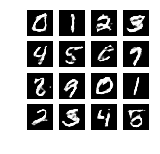

In [8]:
build_and_train_models()

C:\Users\maninaya\Anaconda3\envs\env\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


test_outputs  labels for generated images:  [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


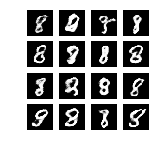

In [10]:
generator = load_model("cgan_mnist.h5")
class_label = 8
test_generator(generator, class_label)

test_outputs  labels for generated images:  [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


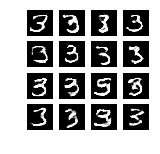

In [11]:
test_generator(generator, 3)

test_outputs  labels for generated images:  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


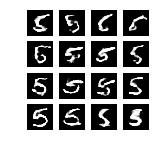

In [12]:
test_generator(generator, 5)